# Lung segmentation from Chest X-Ray dataset



In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/","masks/")

## The images and mask variables are lists of file names in the image_path and mask_path directories, respectively.

In [4]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]


## The mask list is modified to remove the ".png" extension from each file name.

## The image_file_name list is created by extracting the file names from the mask list.


In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


## The check list is created by iterating over the elements in the mask list and keeping only those elements that contain the string "mask" in their name.

Earlier I was going to train on the Shenzhen dataset while perform prediction on the Montgomery dataset. However, the nature of the data was diffrent in both the set. The images from Shenzhen dataset had smaller lung-to-image ratio as compared to the Montgomery dataset.

Thus, I am loading the two dataset seperately which I combined once I got to know about the disparity.

In [6]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
# Montogomery dataset


## The testing_files set is created by taking the intersection of the images and mask lists. This set contains the file names that are present in both lists.



## The training_files set is created by taking the difference between the mask list and the testing_files set. This set contains the file names that are present in the mask list but not in the images list.

In [7]:
training_files = check
# Shenzhen

In [8]:
# The getData() function takes two arguments: X_shape and flag. 
# The X_shape argument specifies the size to which the images and masks 
# should be resized, and the flag argument specifies whether the 
# function should return the test data or the training data

def getData(X_shape, flag = "test"):
    im_array = [] # The function initializes two empty lists: im_array and mask_array. 
                    # These lists will be used to store the processed images and masks.
    mask_array = []
    
    #If the flag argument is "test", the function loops over the file names in the
    # testing_files set and loads the corresponding images and masks from the 
    # file paths. The images and masks are then resized to 
    # the specified X_shape and added to the im_array and mask_array lists, respectively.
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    # If the flag argument is "train", the function loops over the file names 
    # in the training_files set and loads the corresponding images and masks 
    # from the file paths. The images and masks are then resized to the specified 
    # X_shape and added to the im_array and mask_array lists, respectively.
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [9]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(9):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [10]:
# Load training and testing data
dim = 256
# The dim variable specifies the size to which the images and masks should be resized. In this case, the value of dim is set to 256*2, which means that 
# the images and masks will be resized to a size of 256x256 pixels.
X_train,y_train = getData(dim,flag="train")
# The getData() function is called with the dim variable as the first argument 
# and the flag argument set to "train" to load the training data. 
# The function returns the loaded and processed images and masks,
# which are stored in the X_train and y_train variables, respectively.


X_test, y_test = getData(dim)
# The getData() function is then called again with the dim variable
# as the first argument and the default flag argument set to "test" to load the test data. 
# The function returns the loaded and processed images and masks,
# which are stored in the X_test and y_test variables, respectively.

100%|██████████| 138/138 [01:14<00:00,  1.85it/s]


# Perform Sanity Check

It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

training set


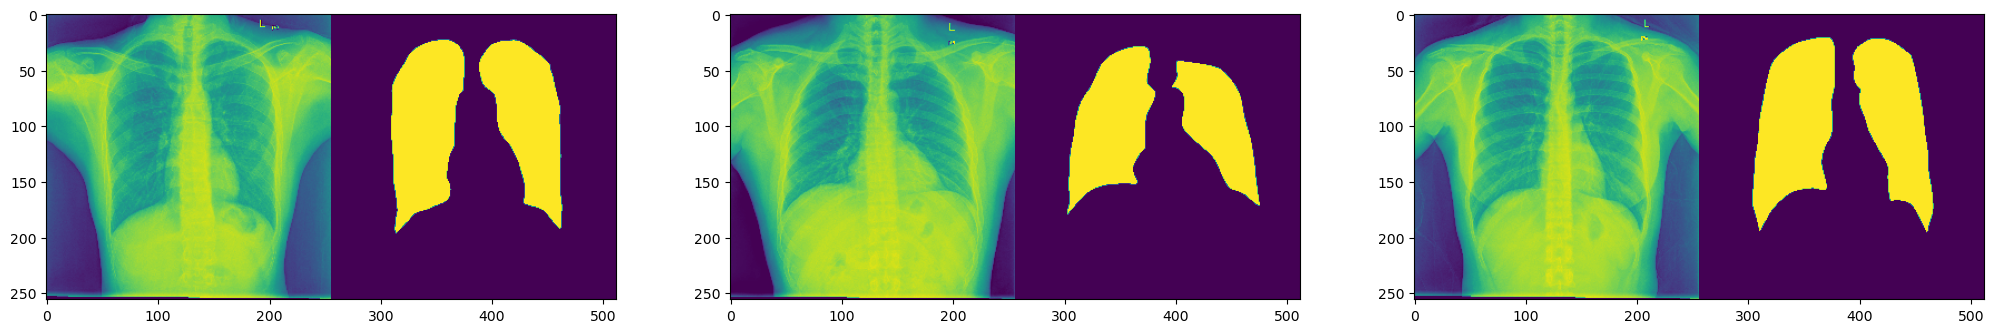

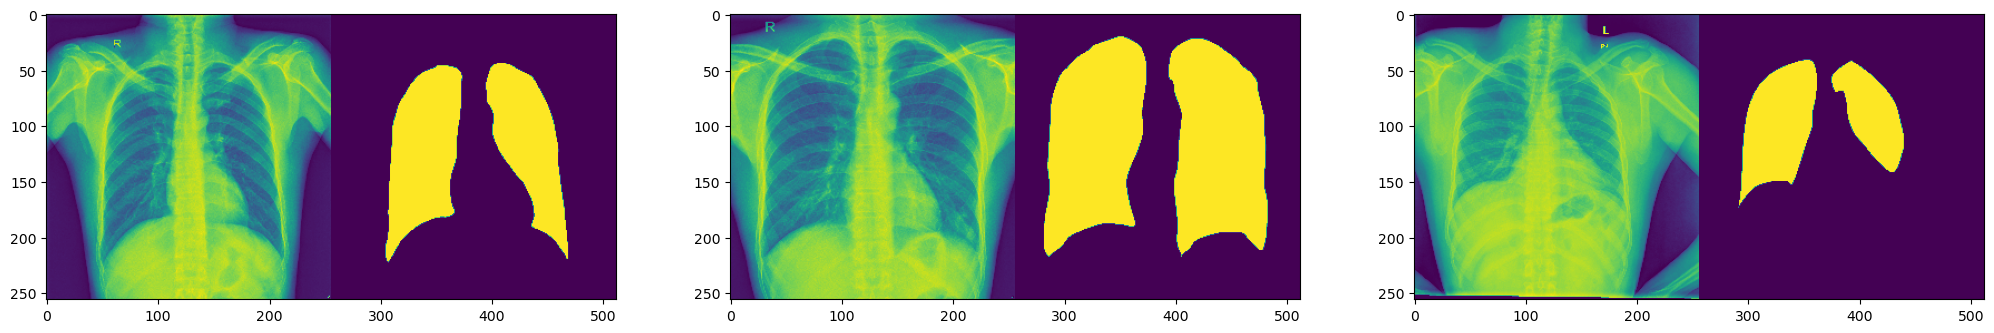

testing set


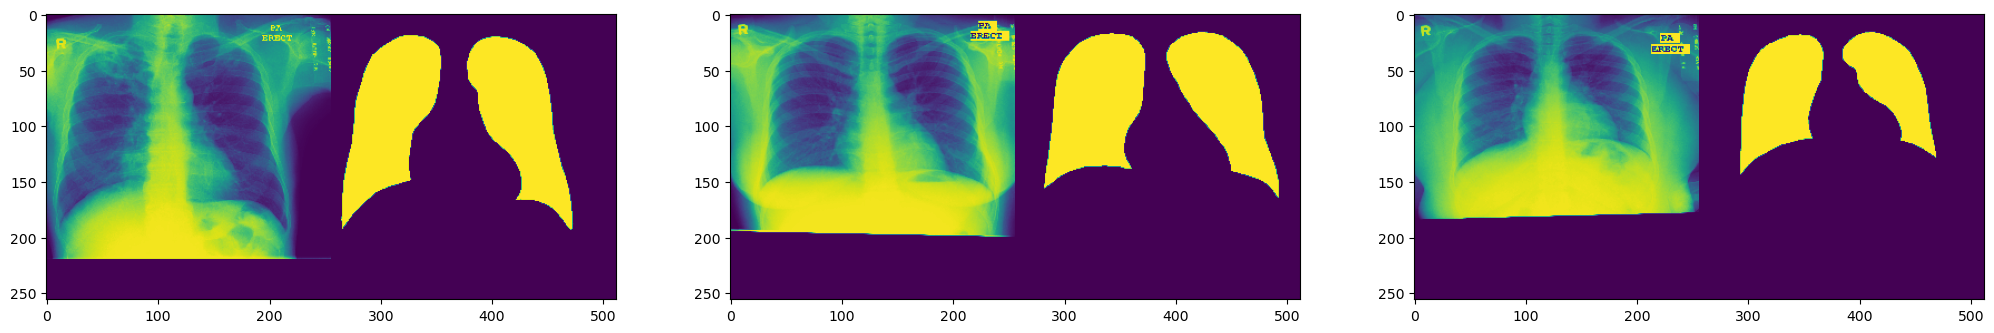

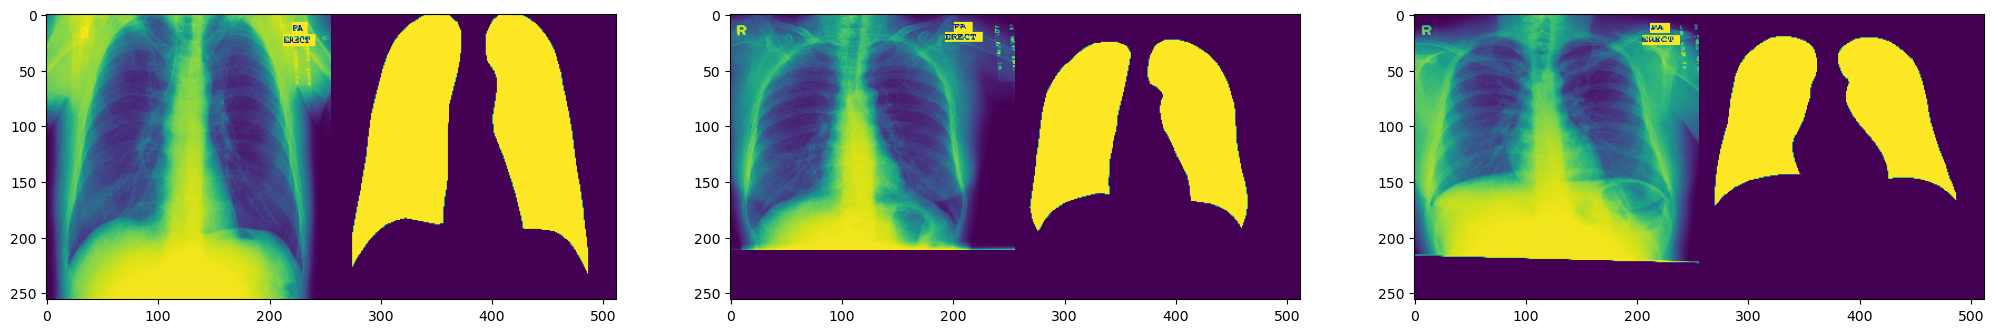

In [11]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [12]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)


In [13]:
print("Before shuffling:")
print(f"images shape: {images.shape}")
print(f"mask shape: {mask.shape}")


Before shuffling:
images shape: (704, 256, 256, 1)
mask shape: (704, 256, 256, 1)


In [14]:
from sklearn.utils import shuffle

images, mask = shuffle(images, mask, random_state=42)

print("\nAfter shuffling:")
print(f"images shape: {images.shape}")
print(f"mask shape: {mask.shape}")


After shuffling:
images shape: (704, 256, 256, 1)
mask shape: (704, 256, 256, 1)


In [15]:
print(f"The shape of the images array is {images.shape}")
print(f"The shape of the mask array is {mask.shape}")

The shape of the images array is (704, 256, 256, 1)
The shape of the mask array is (704, 256, 256, 1)


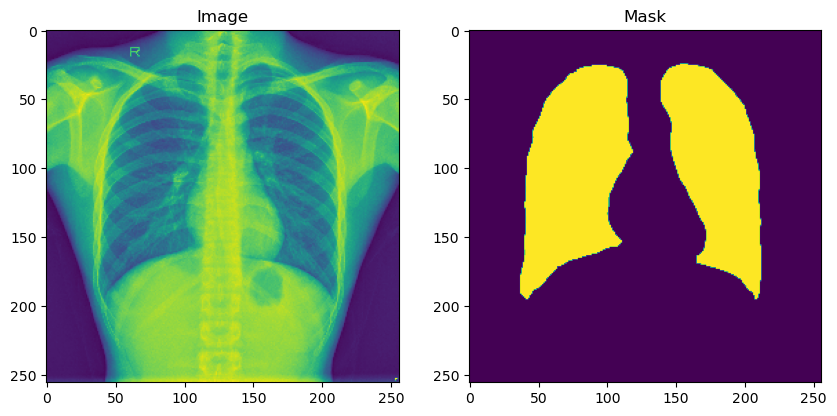

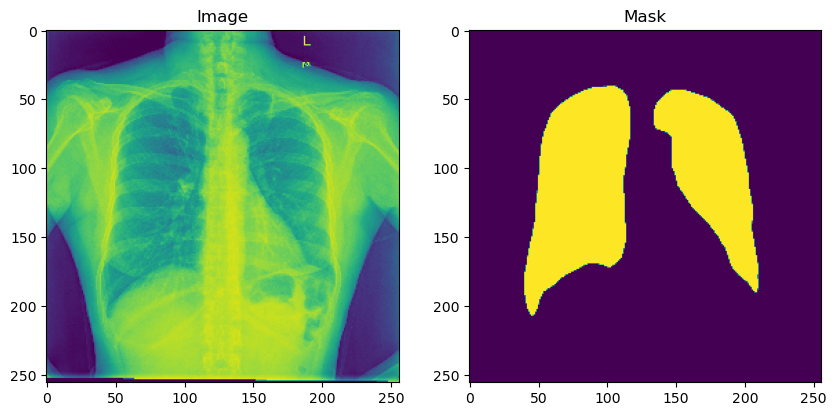

In [16]:
import matplotlib.pyplot as plt

# Display the first image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0,:,:,0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(mask[0,:,:,0])
plt.title("Mask")
plt.show()

# Display the second image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[1,:,:,0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(mask[1,:,:,0])
plt.title("Mask")
plt.show()




## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [17]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    # Flatten the labels
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    # Calculate the intersection
    intersection = keras.sum(y_true_f * y_pred_f)
    # Calculate the union
    union = keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection
    # Calculate the IOU score
    iou_score = intersection / union
    return iou_score

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

#### Compile and train the Unet Model

In [18]:
from tensorflow.keras.optimizers import Adam

def iou(y_true, y_pred):
    # Flatten the labels
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    # Calculate the intersection
    intersection = keras.sum(y_true_f * y_pred_f)
    # Calculate the union
    union = keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection
    # Calculate the IOU score
    iou_score = intersection / union
    return iou_score


model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy', iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Callbacks, Early Stopping and Reduced LR


In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')
from keras.callbacks import LambdaCallback

test_loss = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f'Test loss: {logs["val_loss"]:.5f}'))
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3,
                     restore_best_weights=True) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
callbacks_list.append(test_loss)

#### Train the model

I intially used a 60-40 train-test spit and got a loss of -0.97. However, the better way to do it is 80-10-10 train-test-validation spit. Below I am roughly doing the later.

In [20]:
from sklearn.model_selection import train_test_split


model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy', iou])
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.2,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.2, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 20,
                  validation_data =(validation_vol,validation_seg) ,
                  callbacks=callbacks_list)



Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: -0.5779 - dice_coef: 0.5715 - binary_accuracy: 0.7441 - iou: 0.4133
Epoch 1: val_loss improved from inf to -0.70687, saving model to cxr_reg_weights.best.hdf5
Test loss: -0.70687
57/57 [==============================] - 31s 133ms/step - loss: -0.5779 - dice_coef: 0.5715 - binary_accuracy: 0.7441 - iou: 0.4133 - val_loss: -0.7069 - val_dice_coef: 0.7067 - val_binary_accuracy: 0.8262 - val_iou: 0.5476 - lr: 0.0010
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: -0.7748 - dice_coef: 0.7748 - binary_accuracy: 0.8740 - iou: 0.6463
Epoch 2: val_loss improved from -0.70687 to -0.86712, saving model to cxr_reg_weights.best.hdf5
Test loss: -0.86712
57/57 [==============================] - 5s 90ms/step - loss: -0.7754 - dice_coef: 0.7773 - binary_accuracy: 0.8743 - iou: 0.6497 - val_loss: -0.8671 - val_dice_coef: 0.8672 - val_binary_accuracy: 0.9286 - val_iou: 0.7667 - lr: 0.0010
Epoch 3/20
56/57 [===========

## Plot the metric and evaluate 

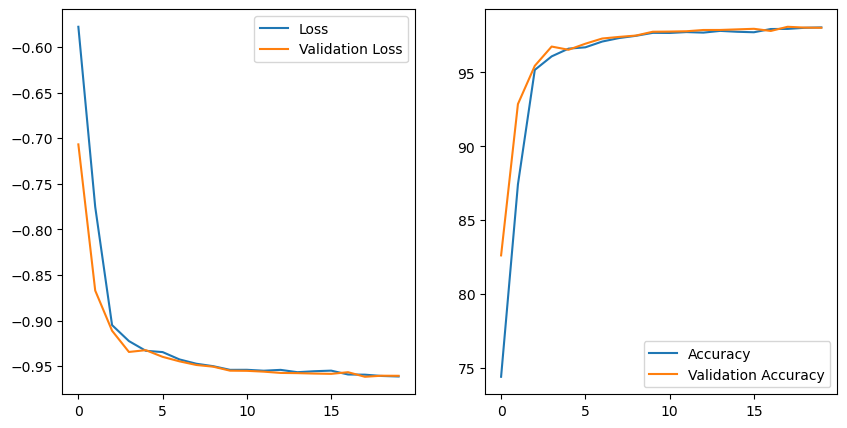

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

## Test the model

4/4 [==============================] - 0s 75ms/step


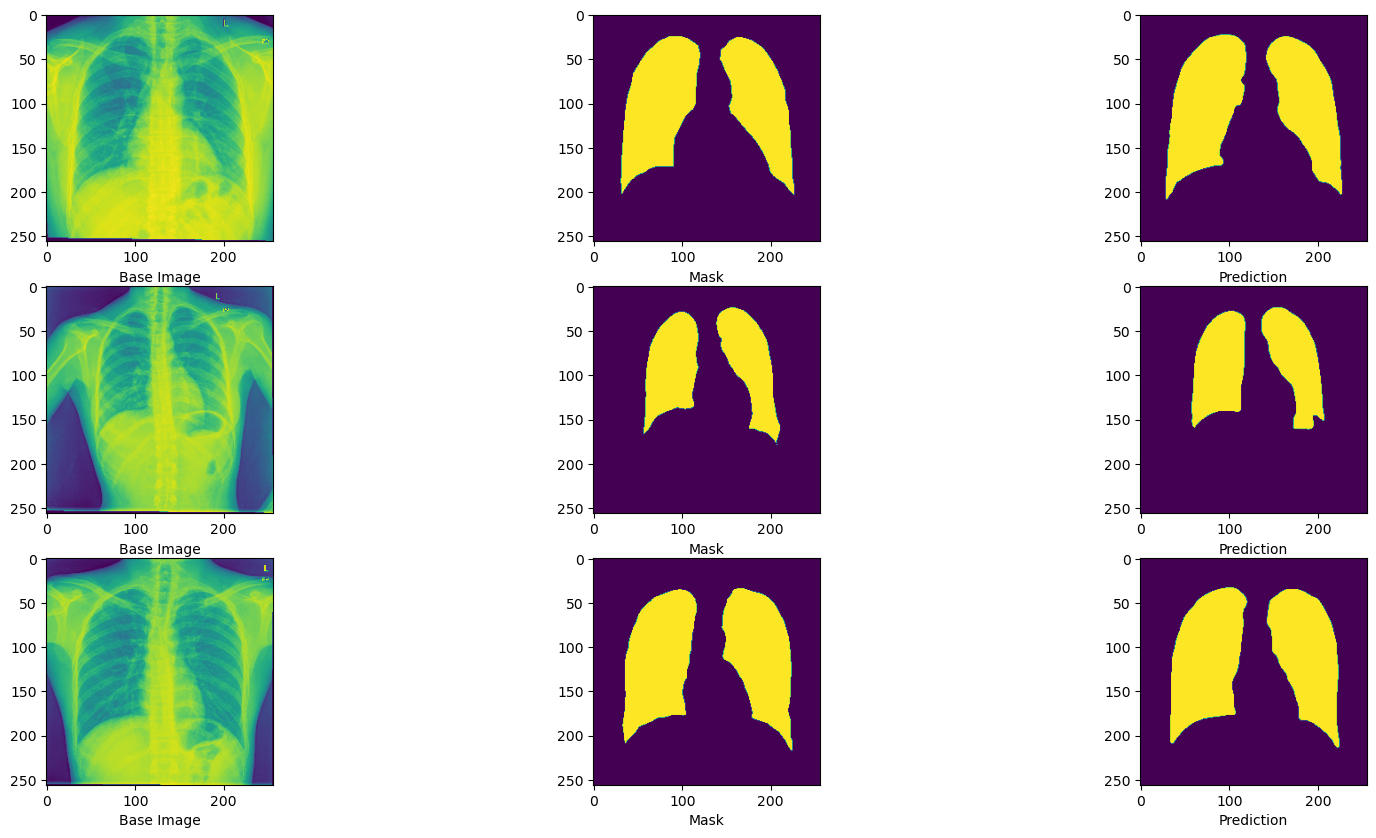

In [23]:
# Predict on test set
test_preds = model.predict(test_vol)

# Visualize some predictions on test set
pred_candidates = np.random.randint(1, test_vol.shape[0], 10)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(test_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(test_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(test_preds[pred_candidates[i]]))
    plt.xlabel("Prediction")


In [24]:
def dice_score1(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

In [25]:
def jaccard_coeff(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

In [26]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Calculate test loss
test_loss = mean_squared_error(test_seg.flatten(), test_preds.flatten())


# Calculate dice score
dice = dice_score1(test_seg.flatten(), test_preds.flatten())

# Calculate IOU (Jaccard score)
iou = jaccard_coeff(test_seg.flatten(), test_preds.flatten())

print(f'Test loss: {test_loss:.5f}')

print(f'Test dice: {dice:.5f}')
print(f'Test IoU: {iou:.5f}')


Test loss: 0.02061
Test dice: 0.95861
Test IoU: 0.92051


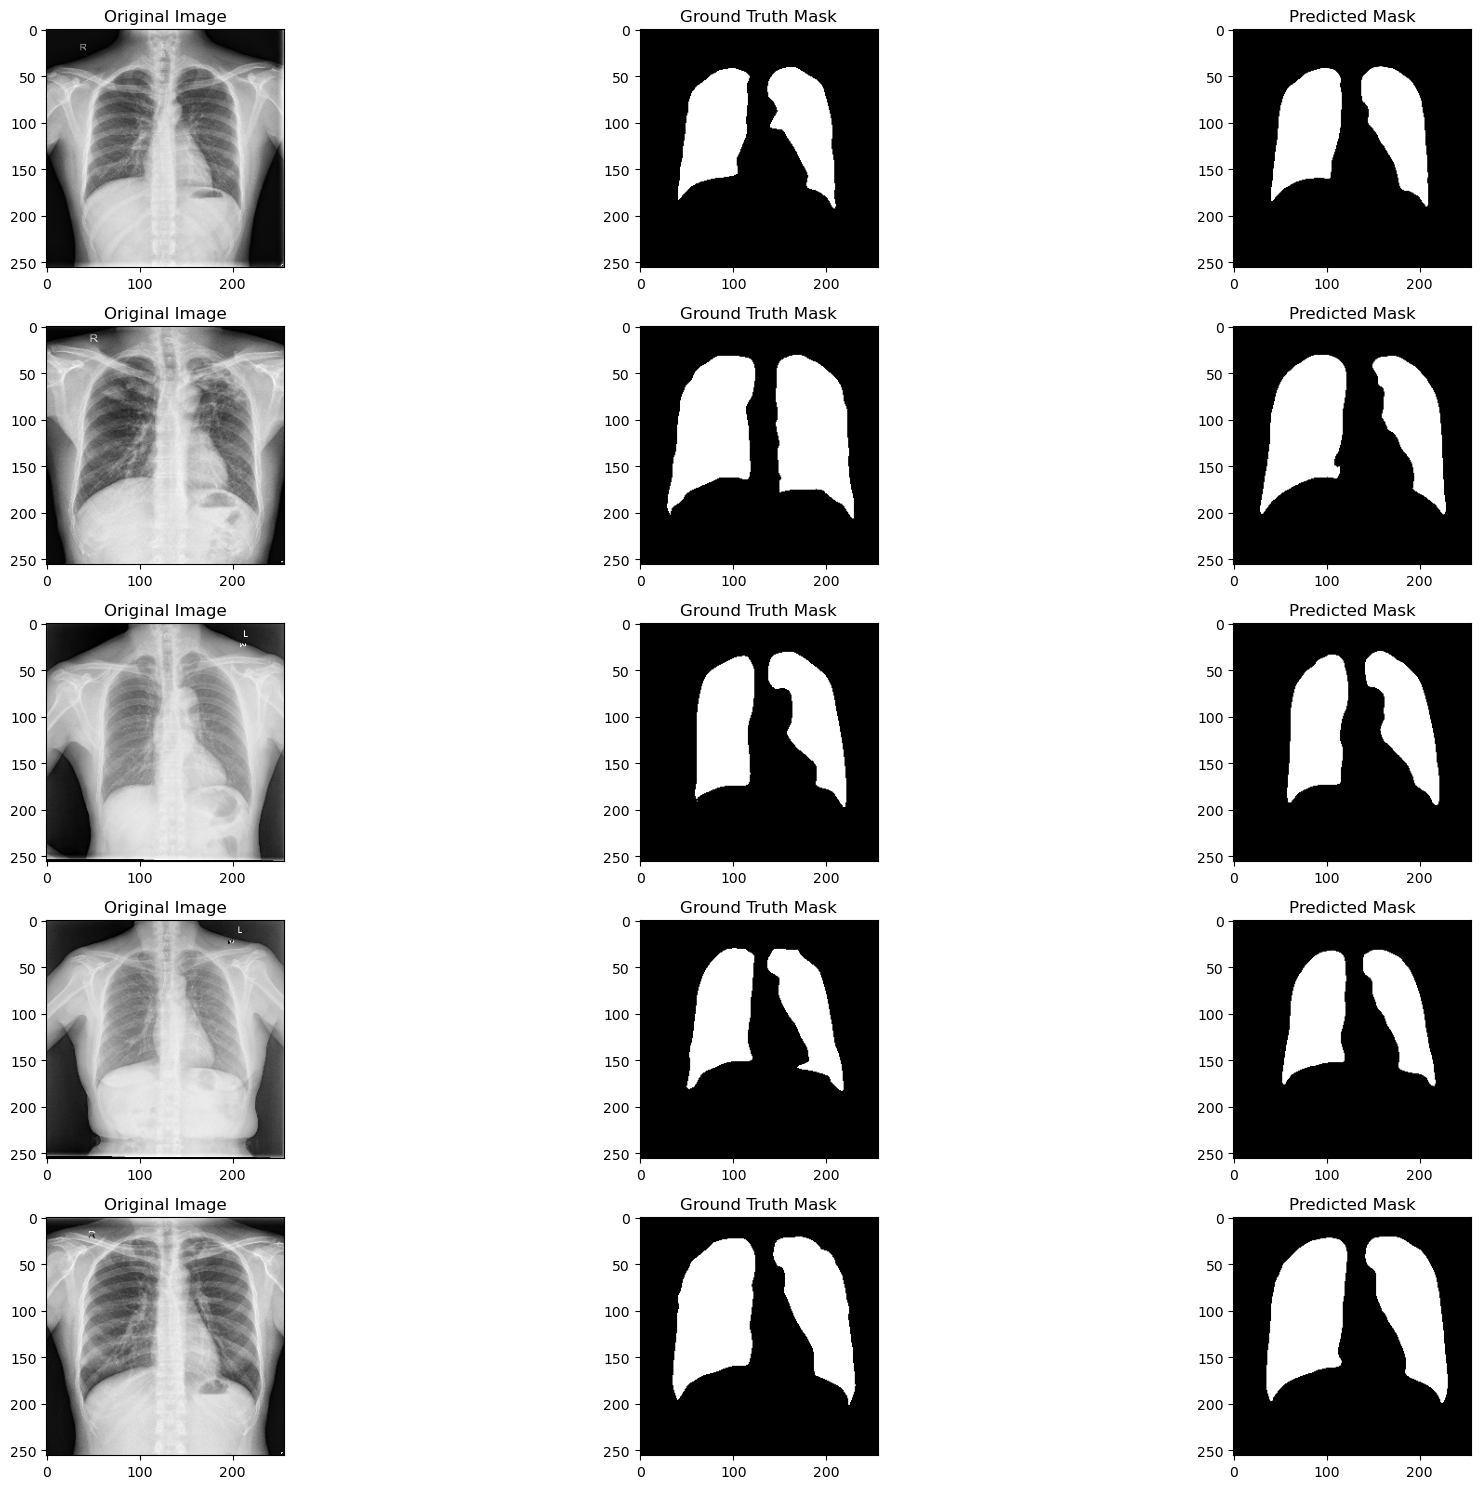

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def display_image_and_masks(img, gt_mask, pred_mask):
    # Resize the image and masks to the same shape for display
    scale_factor = img.shape[0] / gt_mask.shape[0]
    resized_gt_mask = cv2.resize(gt_mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    resized_pred_mask = cv2.resize(pred_mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)


    # Create a new figure to display the original image with the three masks
    plt.figure(figsize=(20, 10))
    
    # Display the original image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    
    # Display the ground truth mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    
    # Display the predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    
    # Display the comparison between the ground truth and predicted masks
    comparison_mask = np.zeros_like(gt_mask)
    comparison_mask[pred_mask == gt_mask] = 255
    comparison_mask[pred_mask != gt_mask] = 128
    plt.subplot(1, 4, 4)
    plt.imshow(comparison_mask, cmap='gray')
    plt.title('Comparison of Predicted and Ground Truth Masks')

# Assuming the variables img, gt_mask, and pred_mask are already defined

# Visualize some predictions on test set
pred_candidates = np.random.randint(1, test_vol.shape[0], 10)

plt.figure(figsize=(25, 15))

for i in range(5):
    # Get the image, ground truth mask, and predicted mask for the current iteration
    img = np.squeeze(test_vol[pred_candidates[i]])
    gt_mask = np.squeeze(test_seg[pred_candidates[i]])
    pred_mask = np.squeeze(test_preds[pred_candidates[i]])

    # Create new figures for each image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')

    

plt.tight_layout()
plt.show()


In [28]:
from IPython.display import clear_output

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/tuberculosis-tb-chest-xray-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

clear_output()


In [29]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
# from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
# from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [30]:
# create helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix


--2023-02-26 19:10:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-26 19:10:13 (38.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [31]:
# load metadata
df_norm = pd.read_excel('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [32]:
# Example of metadata
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [33]:
# Join both normal and tuberculosis excels
# create Label feature ['Tuberculosis']
df_norm['Tuberculosis'] = np.float(0)
df_tb['Tuberculosis'] = np.float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
# Rename column
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [35]:
df

Image  Tuberculosis
0          Normal-3163           0.0
1          Normal-1120           0.0
2          Normal-3439           0.0
3     Tuberculosis-682           1.0
4          Normal-1543           0.0
...                ...           ...
4195       Normal-2435           0.0
4196  Tuberculosis-101           1.0
4197       Normal-1642           0.0
4198       Normal-3322           0.0
4199       Normal-2840           0.0

[4200 rows x 2 columns]

In [36]:
# Walk through directory
ds = "../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'.
There are 0 directories and 700 images in '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'.
There are 0 directories and 3500 images in '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [37]:
# Set the path to the normal and tuberculosis images
SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')

DEST_PATH_NORM = '../output/Normal_lung_region'
DEST_PATH_TB = '../output/Tuberculosis_lung_region'

# Create the destination directories if they do not exist
if not os.path.exists(DEST_PATH_NORM):
  os.makedirs(DEST_PATH_NORM)
if not os.path.exists(DEST_PATH_TB):
  os.makedirs(DEST_PATH_TB)

In [38]:
import cv2

# Loop through the normal images and apply the U-Net model
for filename in os.listdir(SOURCE_PATH_NORM):
  # Load the image
  img = cv2.imread(os.path.join(SOURCE_PATH_NORM, filename))
  # Resize the image to 256x256
  img = cv2.resize(img, (256, 256))
  # Convert the image to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Preprocess the image
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  # Apply the U-Net model
  lung_region = model.predict(img)
  # Save the output image
  cv2.imwrite(os.path.join(DEST_PATH_NORM, filename), lung_region[0] * 255.0)

# Loop through the tuberculosis images and apply the U-Net model
for filename in os.listdir(SOURCE_PATH_TB):
  # Load the image
  img = cv2.imread(os.path.join(SOURCE_PATH_TB, filename))
  # Resize the image to 256x256
  img = cv2.resize(img, (256, 256))
  # Convert the image to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Preprocess the image
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  # Apply the U-Net model
  lung_region = model.predict(img)
  # Save the output image
  cv2.imwrite(os.path.join(DEST_PATH_TB, filename), lung_region[0] * 255.0)

clear_output()



In [ ]:
# Extract ROI

In [ ]:

ROI_PATH_NORM = '../output/ROI_NORM'
ROI_PATH_TB = '../output/ROI_TB'

# Create the destination directories if they do not exist
if not os.path.exists(ROI_PATH_NORM):
  os.makedirs(ROI_PATH_NORM)
if not os.path.exists(ROI_PATH_TB):
  os.makedirs(ROI_PATH_TB)

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import save_img

# Set the ROI path for normal and tuberculosis images
ROI_PATH_NORM = '../output/Normal_ROI'
ROI_PATH_TB = '../output/Tuberculosis_ROI'

# Create the ROI directories if they do not exist
if not os.path.exists(ROI_PATH_NORM):
  os.makedirs(ROI_PATH_NORM)
if not os.path.exists(ROI_PATH_TB):
  os.makedirs(ROI_PATH_TB)

# Loop through the normal images and apply the U-Net model


# Loop through the normal images and apply the U-Net model
for filename in os.listdir(SOURCE_PATH_NORM):
  # Load the image
  img = cv2.imread(os.path.join(SOURCE_PATH_NORM, filename))
  # Resize the image to 256x256
  img = cv2.resize(img, (256, 256))
  # Convert the image to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Preprocess the image
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  # Apply the U-Net model
  lung_region = model.predict(img)
  # Extract the lung region from the image using the mask
  lung_region = img * lung_region[0]
  # Save the output image
  save_img(os.path.join(ROI_PATH_NORM, filename), lung_region[0])
    

# Loop through the tuberculosis images and apply the U-Net model
for filename in os.listdir(SOURCE_PATH_TB):
  # Load the image
  img = cv2.imread(os.path.join(SOURCE_PATH_TB, filename))
  # Resize the image to 256x256
  img = cv2.resize(img, (256, 256))
  # Convert the image to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Preprocess the image
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  # Apply the U-Net model
  lung_region = model.predict(img)
  lung_region = img * lung_region[0]
  # Save the output image
  save_img(os.path.join(ROI_PATH_TB, filename), lung_region[0])


clear_output()



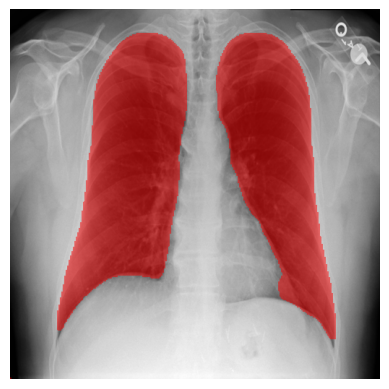

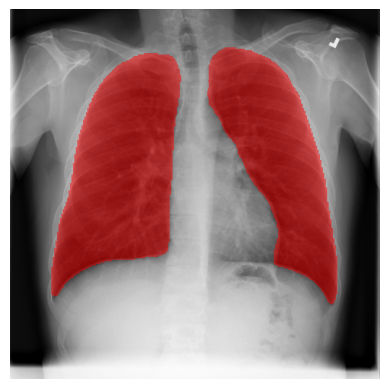

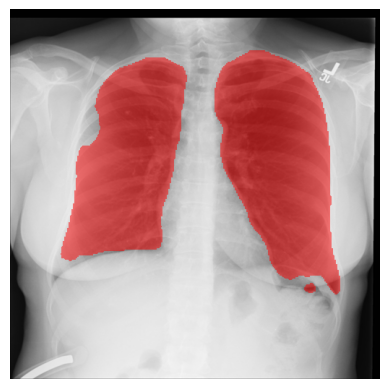

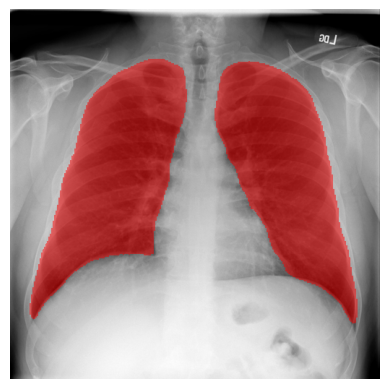

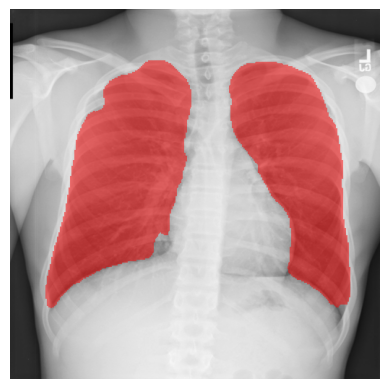

In [43]:
import cv2
import matplotlib.pyplot as plt

# List the files in the DEST_PATH_NORM directory
files = os.listdir(DEST_PATH_NORM)

# Display the first 30 images
for i, file in enumerate(files[:5]):
    # Load the image and mask
    img_path = os.path.join(SOURCE_PATH_NORM, file)
    img = cv2.imread(img_path)
    mask_path = os.path.join(DEST_PATH_NORM, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to match the image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Overlay the mask on top of the image using alpha blending
    alpha = 0.5  # adjust transparency
    overlay = img.copy()
    overlay[mask > 0] = (0, 0, 255)  # set color of mask to red
    output = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    # Display the output image
    plt.imshow(output[:, :, ::-1])  # convert BGR to RGB for display
    plt.axis('off')
    plt.show()


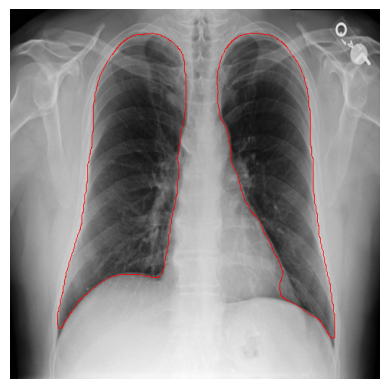

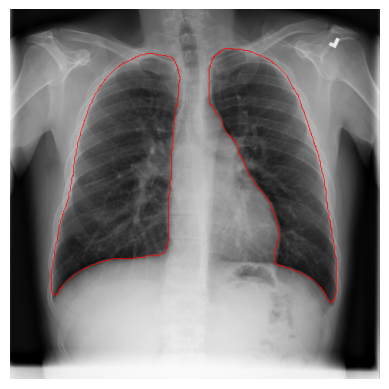

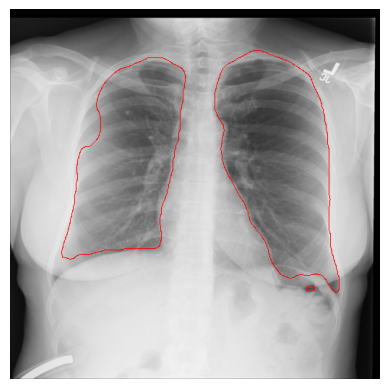

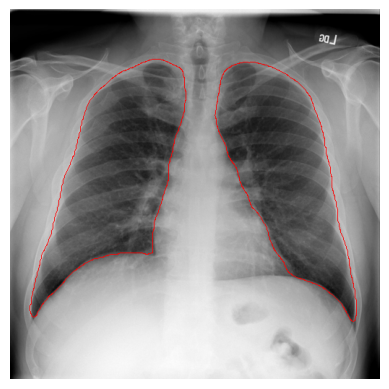

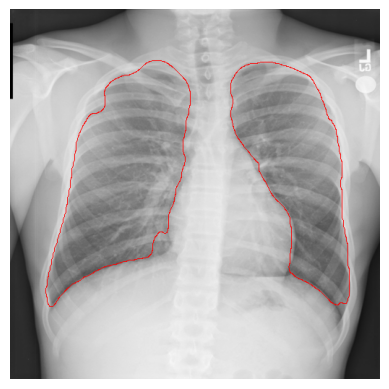

In [44]:
# List the files in the DEST_PATH_NORM directory
files = os.listdir(DEST_PATH_NORM)

# Display the first 5 images
for i, file in enumerate(files[:5]):
    # Load the image and mask
    img_path = os.path.join(SOURCE_PATH_NORM, file)
    img = cv2.imread(img_path)
    mask_path = os.path.join(DEST_PATH_NORM, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to match the image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Apply Canny edge detection on the mask
    edges = cv2.Canny(mask, 100, 200)

    # Set color of edges to red
    output = img.copy()
    output[edges > 0] = (0, 0, 255)

    # Display the output image
    plt.imshow(output[:, :, ::-1])  # convert BGR to RGB for display
    plt.axis('off')
    plt.show()


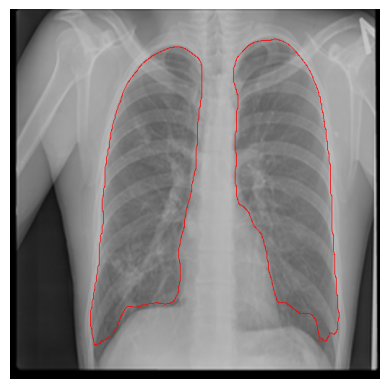

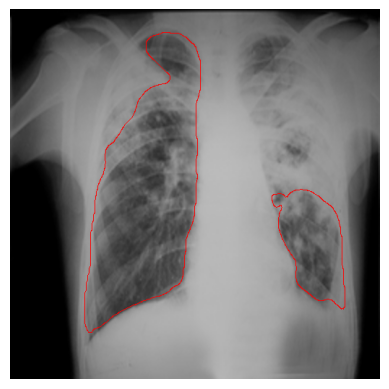

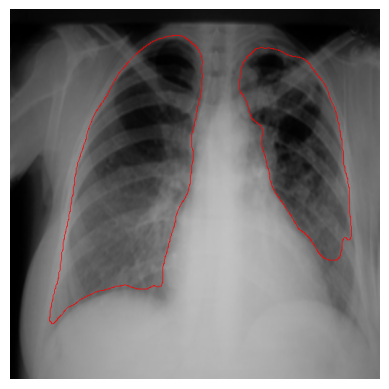

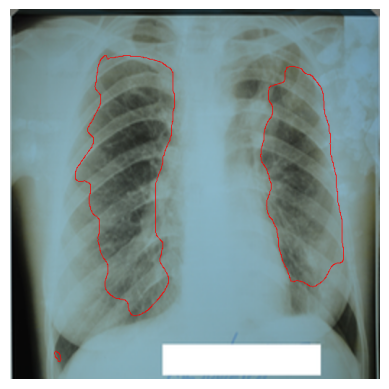

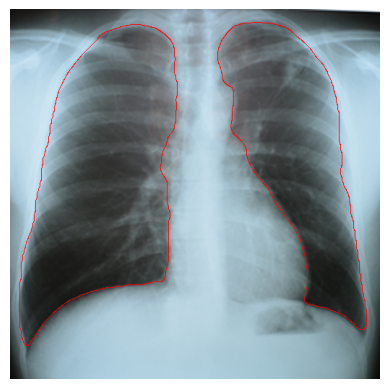

In [45]:
# List the files in the DEST_PATH_NORM directory
files = os.listdir(DEST_PATH_TB)

# Display the first 5 images
for i, file in enumerate(files[:5]):
    # Load the image and mask
    img_path = os.path.join(SOURCE_PATH_TB, file)
    img = cv2.imread(img_path)
    mask_path = os.path.join(DEST_PATH_TB, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to match the image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Apply Canny edge detection on the mask
    edges = cv2.Canny(mask, 100, 200)

    # Set color of edges to red
    output = img.copy()
    output[edges > 0] = (0, 0, 255)

    # Display the output image
    plt.imshow(output[:, :, ::-1])  # convert BGR to RGB for display
    plt.axis('off')
    plt.show()

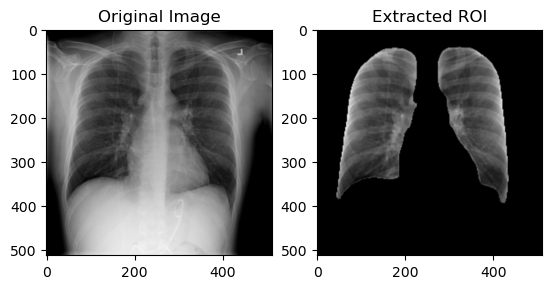

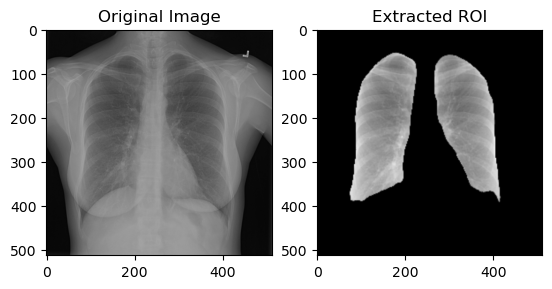

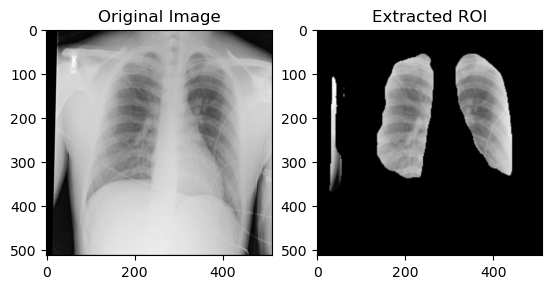

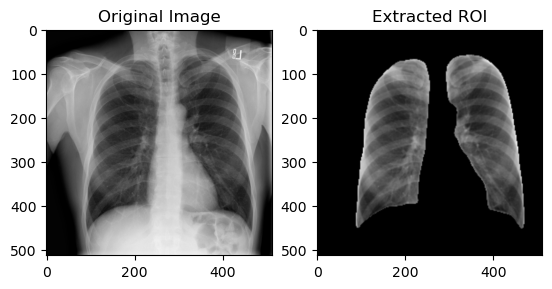

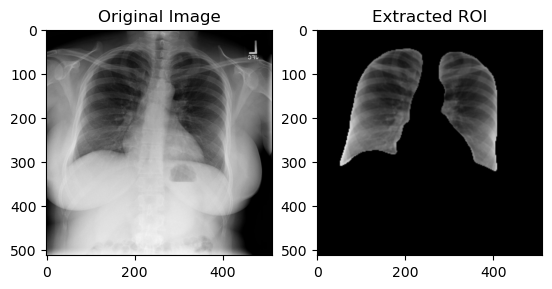

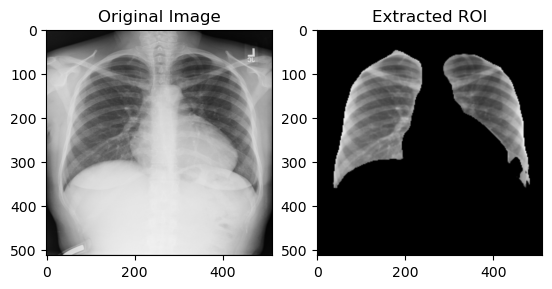

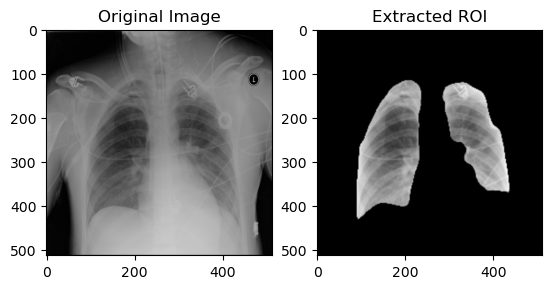

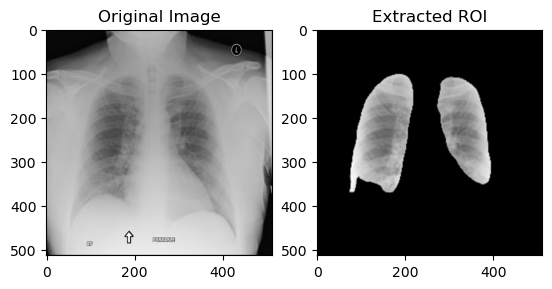

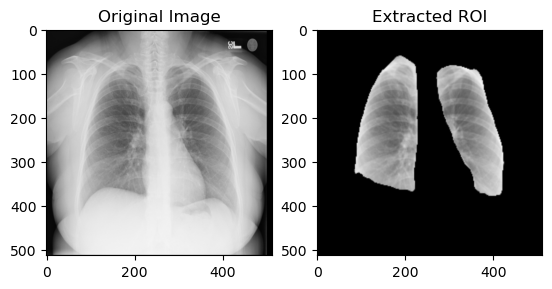

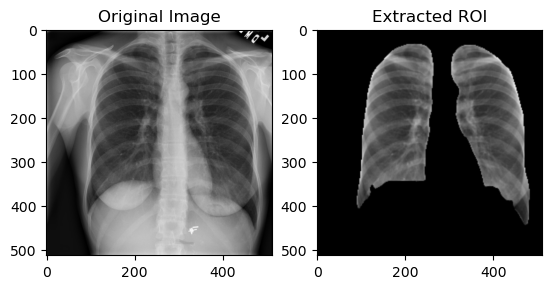

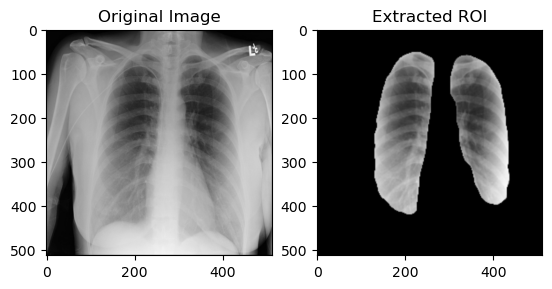

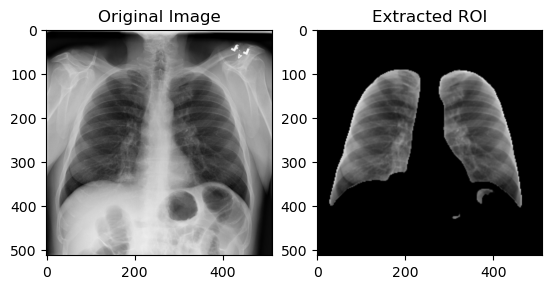

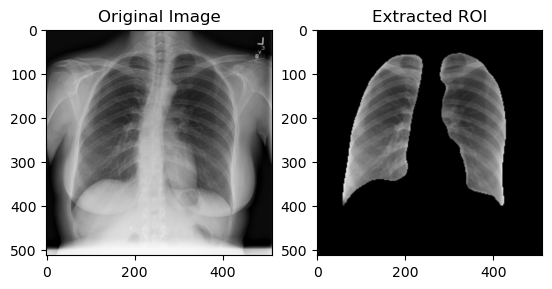

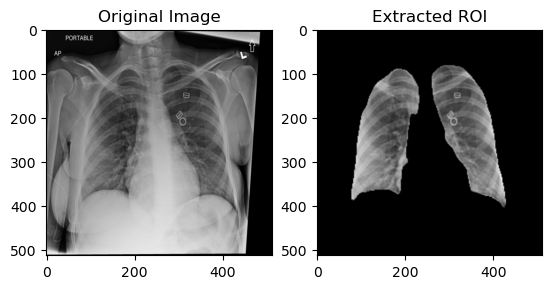

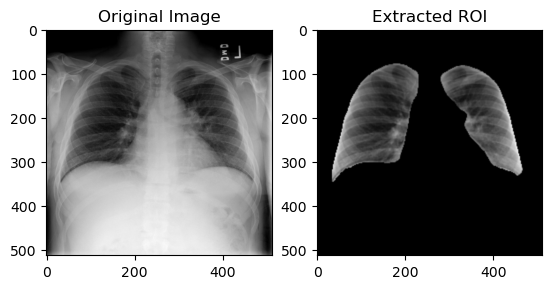

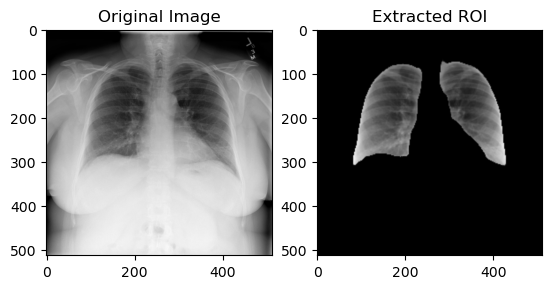

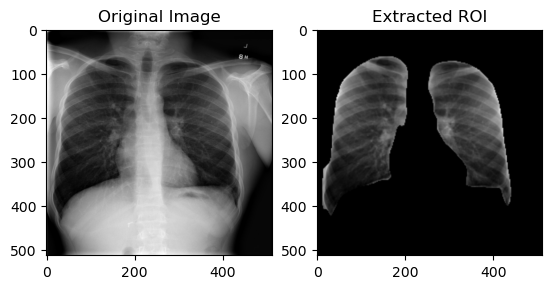

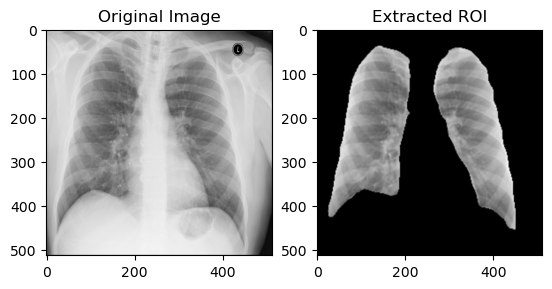

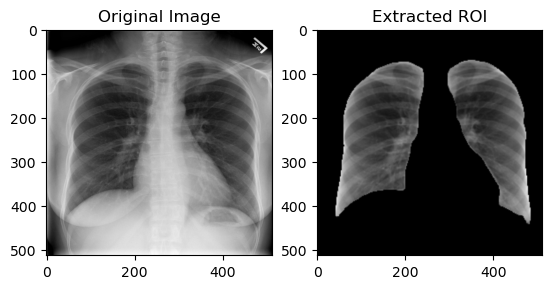

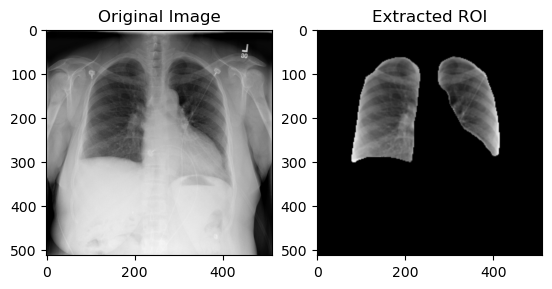

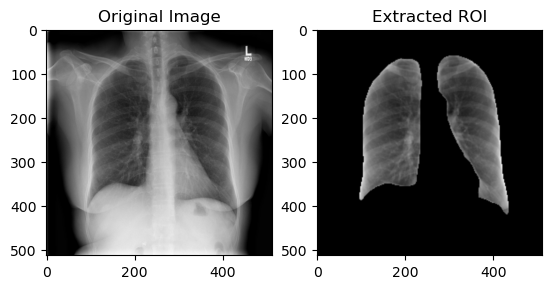

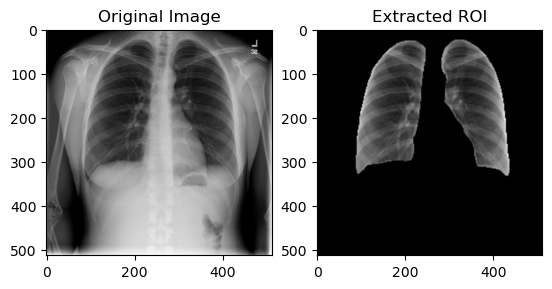

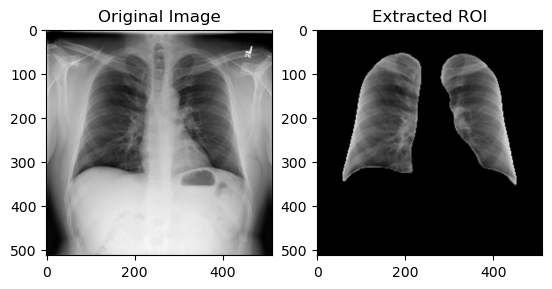

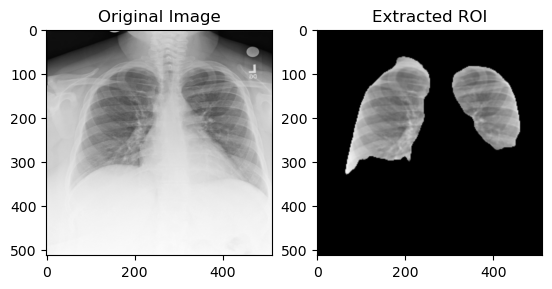

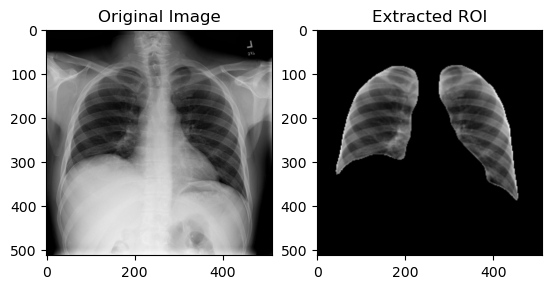

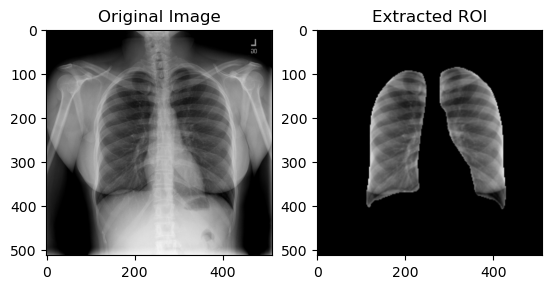

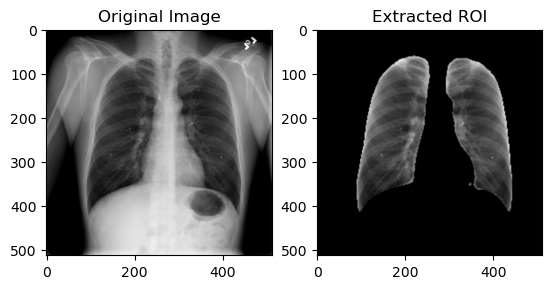

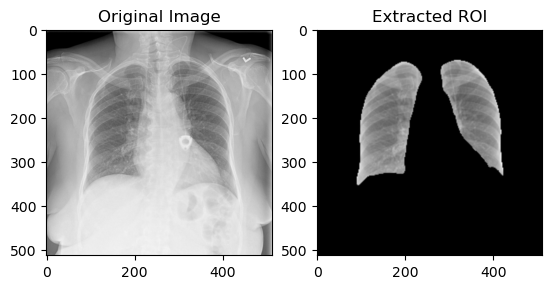

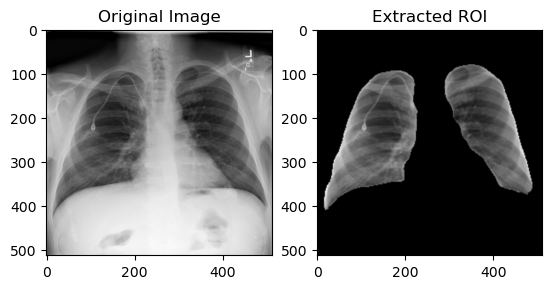

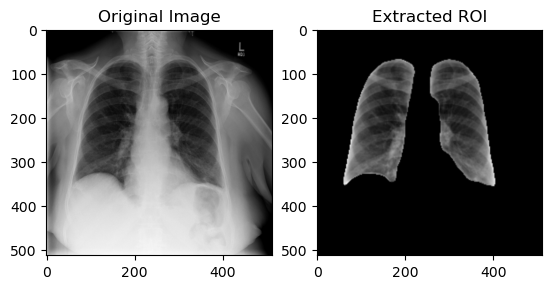

In [42]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt



# Specify the number of images to display
num_images = 30

# Loop through the images and display them
for i, filename in enumerate(os.listdir(SOURCE_PATH_NORM)):
    if i >= num_images:
        break

    # Load the original image
    img = cv2.imread(os.path.join(SOURCE_PATH_NORM, filename))

    # Load the extracted ROI
    roi = cv2.imread(os.path.join(ROI_PATH_NORM, filename))

    # Resize the images to the same size
    height, width, channels = img.shape
    roi = cv2.resize(roi, (width, height))

    # Display the images side by side
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title('Extracted ROI')

    plt.show()

In [47]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.
    
    print("getting train generator...") 
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="binary",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
   
    return train_generator

In [48]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col= 'Image',
        y_col= 'Tuberculosis',
        class_mode="binary",
        batch_size=sample_size,
        shuffle=True,
        seed=seed,
        target_size=(target_w,target_h)
    )
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # create generator with data augmentation for validation set
    val_image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1
    )
    
    # create generator without data augmentation for testing set
    test_image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True
    )
    
    # fit both generators to sample from training data
    val_image_generator.fit(data_sample)
    test_image_generator.fit(data_sample)

    # get val and test generator
    val_generator = val_image_generator.flow_from_dataframe(
        dataframe=val_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="binary",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w,target_h)
    )
# A test generator is a generator that generates samples from the test set.
    test_generator = test_image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="binary",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w,target_h)
    )
    
    return val_generator, test_generator


In [49]:
# Walk through directory
ds = "../output"
walk_through_dir(ds)



SOURCE_PATH_NORM = os.path.join(ds, 'Normal_ROI')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis_ROI')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 6 directories and 0 images in '../output'.
There are 0 directories and 700 images in '../output/Tuberculosis_ROI'.
There are 0 directories and 3500 images in '../output/Normal_ROI'.
There are 0 directories and 0 images in '../output/ROI_TB'.
There are 0 directories and 3500 images in '../output/Normal_lung_region'.
There are 0 directories and 0 images in '../output/ROI_NORM'.
There are 0 directories and 700 images in '../output/Tuberculosis_lung_region'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [ ]:
! ls ../output/

In [50]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal_ROI')
  os.makedirs(train_dir + '/Tuberculosis_ROI')
  os.makedirs(val_dir + '/Normal_ROI')
  os.makedirs(val_dir + '/Tuberculosis_ROI')
  os.makedirs(test_dir + '/Normal_ROI')
  os.makedirs(test_dir + '/Tuberculosis_ROI')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')

In [51]:
# Map train validation test directories

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal_ROI/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal_ROI/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal_ROI/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis_ROI/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis_ROI/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis_ROI/")

In [52]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.6, SPLIT_SIZE_VAL = 0.2):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')
    
  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

    
split_data(ROI_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(ROI_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [53]:
import os

def count_files(path, extension):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(extension):
                count += 1
    return count

# Replace `<extension>` with the file extension of the images you want to count (e.g., '.jpg', '.png', etc.)
num_training_images = count_files(TRAINING_DIR, 'png')
num_validation_images = count_files(VAL_DIR, 'png')
num_testing_images = count_files(TESTING_DIR, 'png')

print(f'Number of training images: {num_training_images}')
print(f'Number of validation images: {num_validation_images}')
print(f'Number of testing images: {num_testing_images}')



Number of training images: 2520
Number of validation images: 840
Number of testing images: 840


In [54]:
import os

def count_files(path, extension):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(extension):
                count += 1
    return count

# Replace `<extension>` with the file extension of the images you want to count (e.g., '.jpg', '.png', etc.)
num_training_norm_images = count_files(TRAINING_NORM_DIR, 'png')
num_training_tb_images = count_files(TRAINING_TB_DIR, 'png')
num_validation_norm_images = count_files(VAL_NORM_DIR, 'png')
num_validation_tb_images = count_files(VAL_TB_DIR, 'png')
num_testing_norm_images = count_files(TESTING_NORM_DIR, 'png')
num_testing_tb_images = count_files(TESTING_TB_DIR, 'png')

print(f'Number of training "Normal" images: {num_training_norm_images}')
print(f'Number of training "Tuberculosis" images: {num_training_tb_images}')
print(f'Number of validation "Normal" images: {num_validation_norm_images}')
print(f'Number of validation "Tuberculosis" images: {num_validation_tb_images}')
print(f'Number of testing "Normal" images: {num_testing_norm_images}')
print(f'Number of testing "Tuberculosis" images: {num_testing_tb_images}')


Number of training "Normal" images: 2100
Number of training "Tuberculosis" images: 420
Number of validation "Normal" images: 700
Number of validation "Tuberculosis" images: 140
Number of testing "Normal" images: 700
Number of testing "Tuberculosis" images: 140


In [55]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [56]:
len(os.listdir(IMAGE_DIR))

4200

In [57]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [58]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [59]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [60]:
from IPython.display import display
display(train_df)

Image  Tuberculosis
0          Normal-1120           0.0
1          Normal-3439           0.0
2     Tuberculosis-682           1.0
3          Normal-2797           0.0
4          Normal-2358           0.0
...                ...           ...
2515        Normal-886           0.0
2516       Normal-2435           0.0
2517  Tuberculosis-101           1.0
2518       Normal-1642           0.0
2519       Normal-2840           0.0

[2520 rows x 2 columns]

In [61]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [62]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


In [63]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

Normal


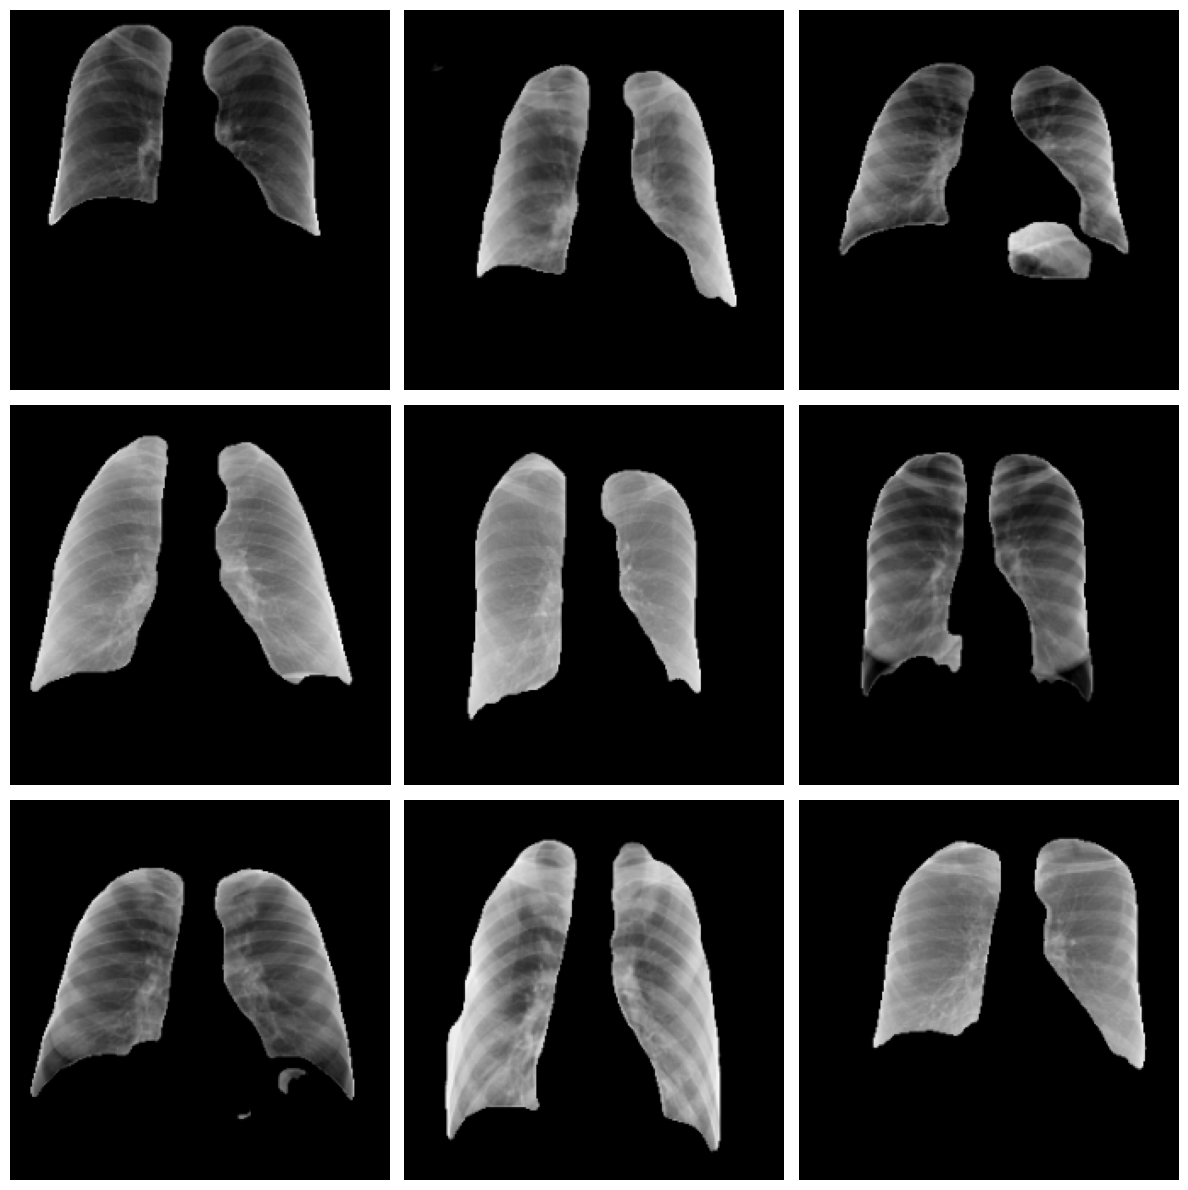

In [64]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


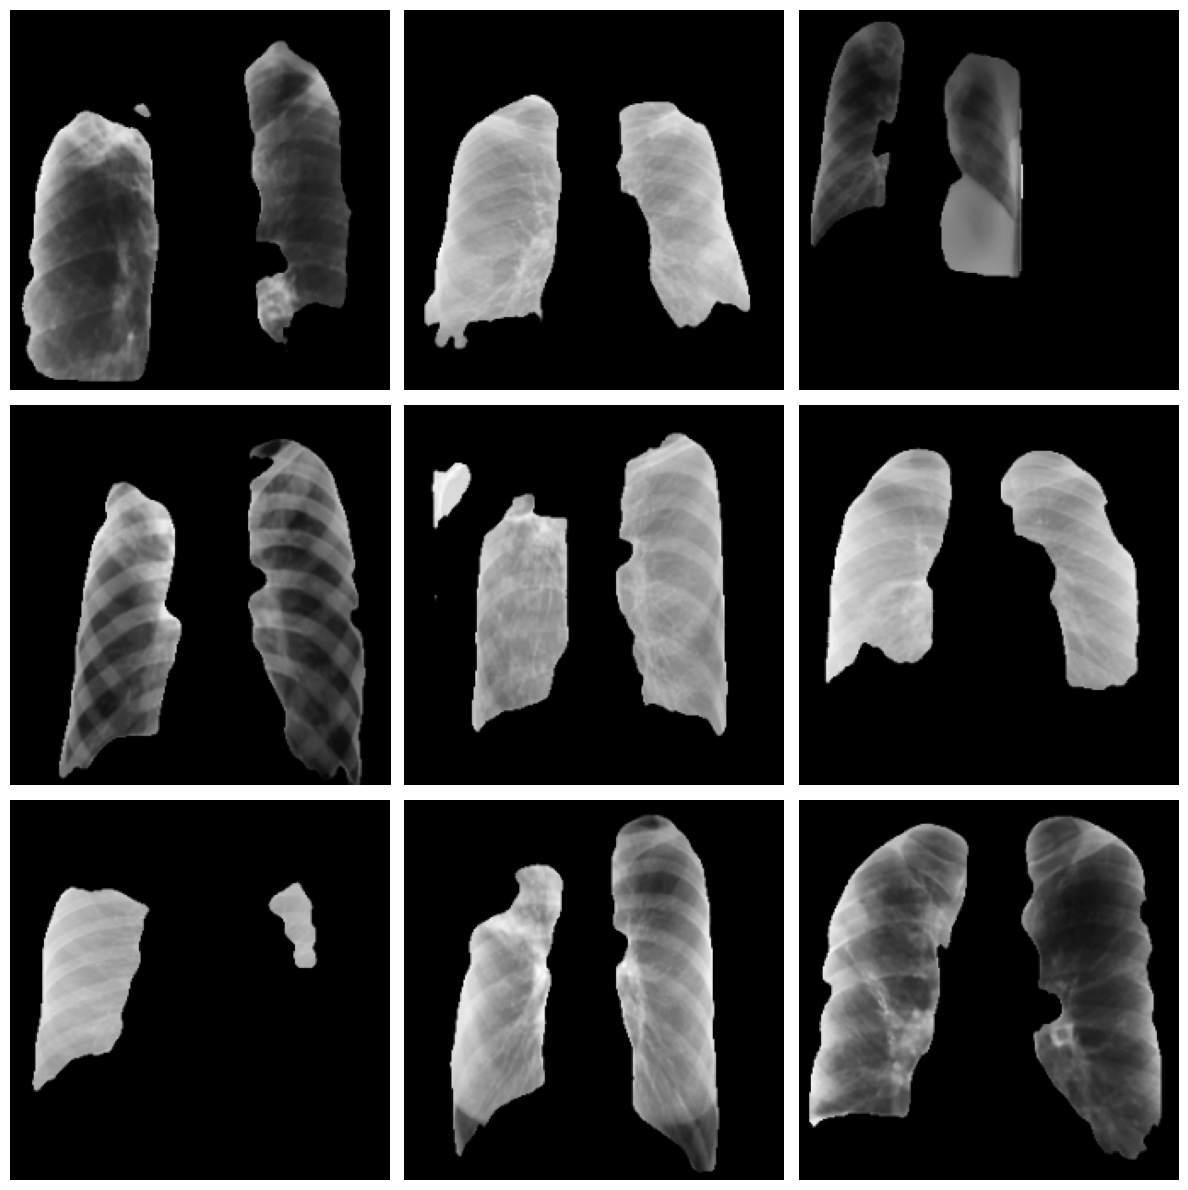

In [65]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [66]:
train_df['Tuberculosis'] = train_df['Tuberculosis'].astype(str)


In [67]:
val_df['Tuberculosis'] = val_df['Tuberculosis'].astype(str)


In [68]:
test_df['Tuberculosis'] = test_df['Tuberculosis'].astype(str)


In [69]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 2520 validated image filenames belonging to 2 classes.
getting val and test generators...
Found 2520 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.


In [70]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [71]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

In [72]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [73]:
# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

In [74]:
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

# create the base pre-trained model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

x = base_model.output

# add a flattening layer
x = Flatten()(x)

# add a dense layer with 128 units
x = Dense(128, activation='relu')(x)

# add a logistic layer
output = Dense(1, activation="sigmoid")(x)
# compile the model with the SGD optimizer
sgd = SGD(lr=0.001)
model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=["accuracy","AUC"])


80134624/80134624 [==============================] - 3s 0us/step


In [75]:
# callbacks 

checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
#RLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 2, min_lr =0.001)
#ES = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 2)

In [76]:
# fit model
history = model.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps= 30,  
                              epochs = 15,
                              callbacks = [MC])

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7987 - auc: 0.5901
Epoch 1: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 45s 379ms/step - loss: 0.5273 - accuracy: 0.7987 - auc: 0.5901 - val_loss: 0.4333 - val_accuracy: 0.8000 - val_auc: 0.8097
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8325 - auc: 0.7612
Epoch 2: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 41s 411ms/step - loss: 0.4042 - accuracy: 0.8325 - auc: 0.7612 - val_loss: 0.4347 - val_accuracy: 0.8042 - val_auc: 0.8868
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8662 - auc: 0.8662
Epoch 3: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 38s 377ms/step - loss: 0.3179 - accuracy: 0.8662 - auc: 0.8662 - val_loss: 0.3642 - val_accuracy: 0.8208 - val_auc: 0.9339
Epoch 4/15
100/100 [==============

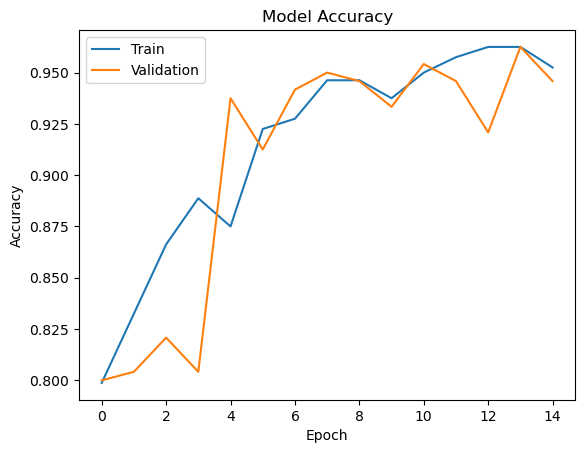

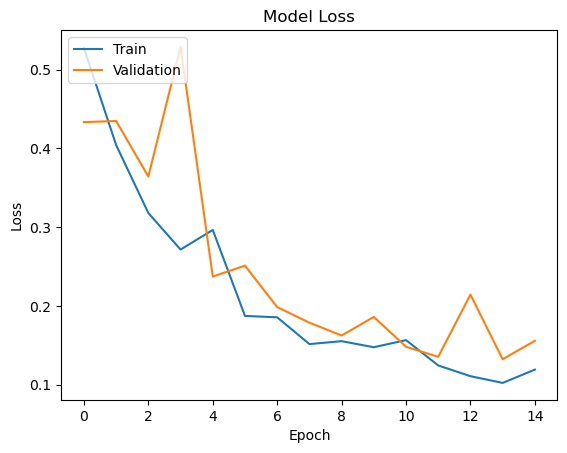

In [77]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [78]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten() 

In [79]:
y_test = test_df['Tuberculosis']


In [80]:
y_test = y_test.astype(float).astype(int)


In [81]:
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       700
           1       0.95      0.80      0.87       140

    accuracy                           0.96       840
   macro avg       0.96      0.90      0.92       840
weighted avg       0.96      0.96      0.96       840

Accuracy of the Model: 95.95238095238095 %


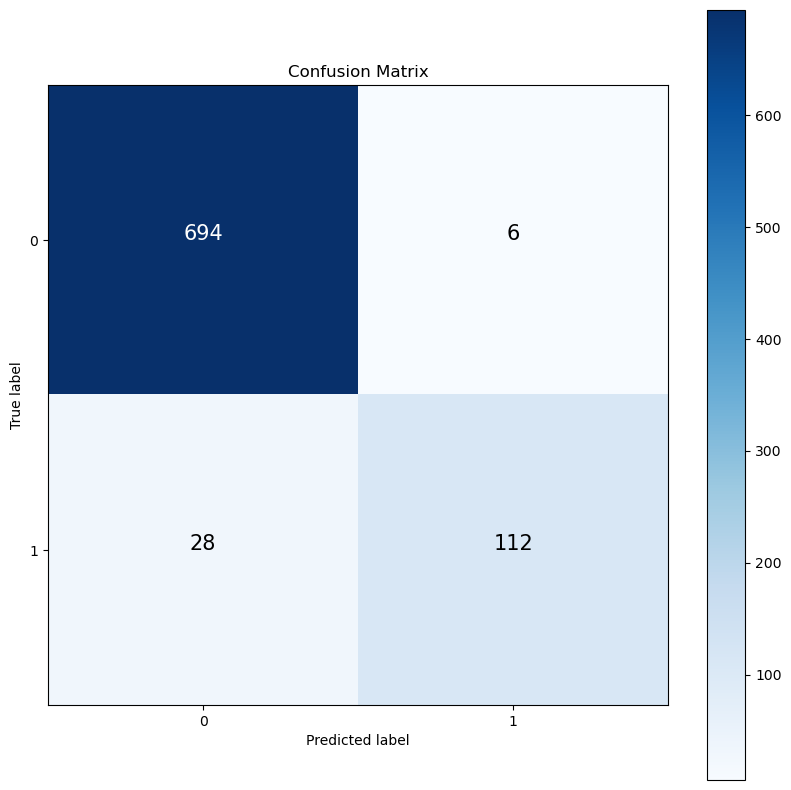

In [82]:
make_confusion_matrix(y_test, y_pred)

In [83]:
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score


# calculate recall
recall = recall_score(y_test, y_pred)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# calculate F1 score
f1 = f1_score(y_test, y_pred)


# calculate precision
precision = precision_score(y_test, y_pred)

# print precision
print("Precision:", precision)

print("Recall: {:.2f}".format(recall))
print("Accuracy: {:.2f}".format(accuracy))
print("Specificity: {:.2f}".format(specificity))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.9491525423728814
Recall: 0.80
Accuracy: 0.96
Specificity: 0.99
F1 Score: 0.87


In [ ]:
## DENSENET

In [84]:
from tensorflow.keras.optimizers import SGD

## create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=["accuracy","AUC"])

29084464/29084464 [==============================] - 2s 0us/step


In [85]:
# fit model
history = model.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps= 30,  
                              epochs = 15,
                              callbacks = [MC])

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8925 - auc: 0.9199
Epoch 1: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 85s 424ms/step - loss: 0.2493 - accuracy: 0.8925 - auc: 0.9199 - val_loss: 0.3154 - val_accuracy: 0.8875 - val_auc: 0.9621
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9425 - auc: 0.9513
Epoch 2: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 43s 432ms/step - loss: 0.1809 - accuracy: 0.9425 - auc: 0.9513 - val_loss: 0.1831 - val_accuracy: 0.9250 - val_auc: 0.9709
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9513 - auc: 0.9715
Epoch 3: saving model to ./training_1/cp.ckpt
100/100 [==============================] - 39s 390ms/step - loss: 0.1473 - accuracy: 0.9513 - auc: 0.9715 - val_loss: 0.1938 - val_accuracy: 0.9417 - val_auc: 0.9833
Epoch 4/15
100/100 [==============

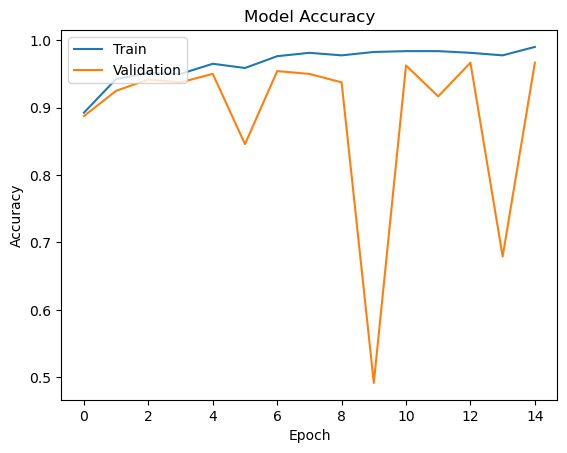

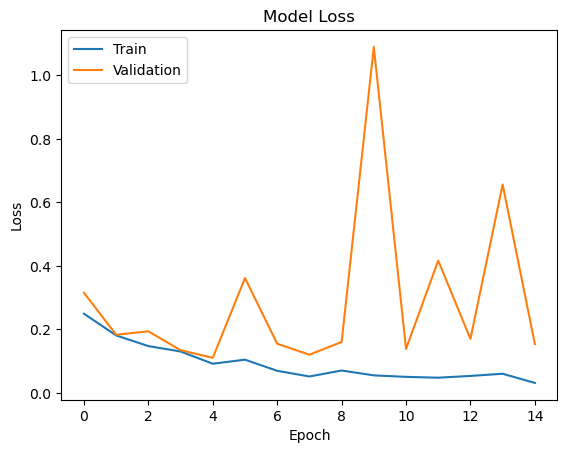

In [86]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [87]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten() 

In [88]:
y_test = test_df['Tuberculosis']


In [89]:
y_test = y_test.astype(float).astype(int)


In [90]:
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       700
           1       0.98      0.79      0.88       140

    accuracy                           0.96       840
   macro avg       0.97      0.90      0.93       840
weighted avg       0.96      0.96      0.96       840

Accuracy of the Model: 96.30952380952381 %


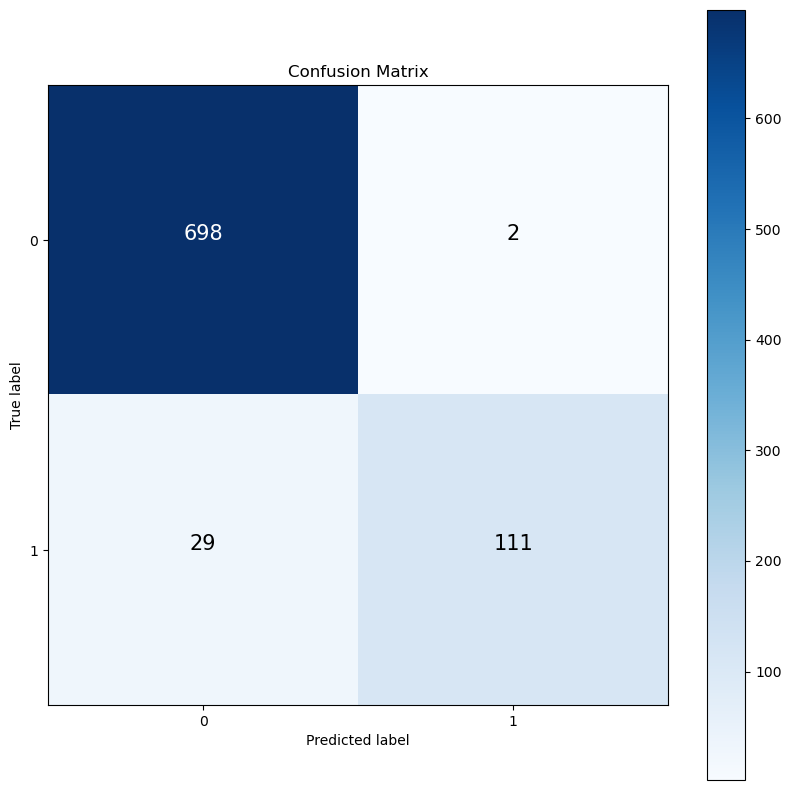

In [91]:
make_confusion_matrix(y_test, y_pred)

In [92]:
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score


# calculate recall
recall = recall_score(y_test, y_pred)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# calculate F1 score
f1 = f1_score(y_test, y_pred)


# calculate precision
precision = precision_score(y_test, y_pred)

# print precision
print("Precision:", precision)

print("Recall: {:.2f}".format(recall))
print("Accuracy: {:.2f}".format(accuracy))
print("Specificity: {:.2f}".format(specificity))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.9823008849557522
Recall: 0.79
Accuracy: 0.96
Specificity: 1.00
F1 Score: 0.88
